# Расчет проводимости трубопроводов с помощью МУК

In [1]:
import os
import math
import numpy as np
from graph import Graph
from matplotlib import pyplot as plt

## Прямоугольное сечение

### Угловые коэффициенты

In [2]:
def scalar_prod(v_1, v_2):
    v_1 , v_2 = np.array(v_1), np.array(v_2)
    return (v_1*v_2).sum()

def module(v):
    return math.sqrt( scalar_prod(v, v) )

def elementary(center_i : list, center_j : list, normal_i : list, normal_j : list, F_j):
    #F_j - площадь одной ячейки коллектора
    center_i, center_j = np.array(center_i), np.array(center_j)
    
    r        = module(center_i - center_j)
    n_i, n_j = module(normal_i), module(normal_j)
    
    cos_1 = abs( scalar_prod( normal_i, center_j - center_i ) ) / (r*n_i)
    cos_2 = abs( scalar_prod( normal_j, center_i - center_j ) ) / (r*n_j)
    return cos_1*cos_2/(math.pi*r**2)*F_j

In [3]:
def local(center_i, centers_2, normal_i, normal_j, F_j):
    #F_j - площадь одной ячейки коллектора
    return sum([ elementary(center_i, center, normal_i, normal_j, F_j) for center in centers_2])

def total(centers_1, centers_2,normal_1, normal_2, F_i, F_j):
    #F_i - площадь одной ячейки эмиттера
    return sum( [ local(center, centers_2, normal_1, normal_2, F_j) for center in centers_1 ] ) * F_i

### Проводимость

In [4]:
#функции разбиения каждой отдельной поверхности на ячейки
def breaking_1(a, b, l, s = 0) -> list:
    res = []
    for i in range(l):
        x = a/(2*l) + a/l*i
        for j in range(l):
            z = b/(2*l) + b/l*j
            center = [x,0,z]
            res.append(center)
    return res

def breaking_2(a, b, l, s) -> list:
    res = []
    for i in range(l):
        x = a/(2*l) + a/l*i
        for j in range(l):
            z = b/(2*l) + b/l*j
            center = [x,s,z]
            res.append(center)
    return res

def breaking_3(a, b, l, s) -> list:
    res = []
    for i in range(l):
        x = a/(2*l) + a/l*i
        for j in range(l):
            y = s/(2*l) + s/l*j
            center = [x,y,b]
            res.append(center)
    return res

def breaking_4(a, b, l, s) -> list:
    res = []
    for i in range(l):
        y = s/(2*l) + s/l*i
        for j in range(l):
            z = b/(2*l) + b/l*j
            center = [0,y,z]
            res.append(center)
    return res

def breaking_5(a, b, l, s) -> list:
    res = []
    for i in range(l):
        x = a/(2*l) + a/l*i
        for j in range(l):
            y = s/(2*l) + s/l*j
            center = [x,y,0]
            res.append(center)
    return res

def breaking_6(a, b, l, s) -> list:
    res = []
    for i in range(l):
        y = s/(2*l) + s/l*i
        for j in range(l):
            z = b/(2*l) + b/l*j
            center = [a,y,z]
            res.append(center)
    return res

In [5]:
#площади "уникальных" поверхностей - area_1 == area_2 etc
def area_1(a,b,s):
    return a*b

def area_3(a,b,s):
    return a*s

def area_4(a,b,s):
    return s*b

In [6]:
class Conduct:
    def __init__(self, a, b, L):
        self.a = a
        self.b = b
        self.L = L
        #1-входное, 2-выходное сечения
        #3-верхняя,5-нижняя грани
        #если смотреть в направлении от 1 к 2, то 3,4,5 и 6 грани пронумерованы по часовой стрелке
        self.normals  = [ [0,1,0], [0,1,0], [0,0,1], [1,0,0], [0,0,1], [1,0,0] ]
        self.breaking = [ breaking_1, breaking_2, breaking_3, breaking_4, breaking_5, breaking_6 ]
        self.areas    = [ area_1, area_1, area_3, area_4, area_3, area_4 ]
        
    def calc(self, j, l_1 = 10, l_2 = 10):
        #j - номер коллектора от 1 до 6
        #l_1, l_2 - на сколько частей разбить эмиттеры и коллектор
        j-=1 #номер коллектора в массивах
        
        #параметры коллектора
        collector = self.breaking[j](self.a,self.b,l_2,self.L)
        normal_j  = self.normals[j]
        area_j    = self.areas[j](self.a,self.b,self.L)/l_2**2
        
        #параметры эмиттеров
        normals_i = [self.normals[i]   for i in range(6) if i != j]
        emitters  = [self.breaking[i]  for i in range(6) if i != j]
        areas_i   = [self.areas[i](self.a,self.b,self.L) for i in range(6) if i != j]
        
        res = 0
        for i in range(5):
            emitter  = emitters[i](self.a,self.b,l_1,self.L)
            normal_i = normals_i[i]
            area_i   = areas_i[i]/l_1**2
            
            res += total(emitter, collector, normal_i, normal_j, area_i, area_j)/areas_i[i]
        return res

### Тестирование

In [7]:
#тесты на сами УК
def test_1(c):
    #совпадают ли потоки на симметричные поверхности
    print("1-й = 2-му:", round(c.calc(1,14,14),6) == round(c.calc(2, 14, 14),6))
    for i in range(3,5):
        print(str(i)+"-й = "+str(i+2)+"-му:", round(c.calc(i,14,14),6) == round(c.calc(i+2, 14, 14),6))
    print("\n")
    return

def test_2(c):
    #меньше ли 1
    for i in [1,3,4]:
        print(str(i)+"-й УК меньше 1:", round(c.calc(i,14,14),6) <= 1)
    print("\n")
    return
    
def test_3(c):
    #больше ли 0
    for i in [1,3,4]:
        print(str(i)+"-й УК больше 0:", round(c.calc(i,14,14),6) >= 0)
    print("\n")
    return

In [8]:
c_1, c_2 = Conduct(1,1,1), Conduct(1,5,1)
test_1(c_1)
test_1(c_2)

1-й = 2-му: True
3-й = 5-му: True
4-й = 6-му: True


1-й = 2-му: True
3-й = 5-му: True
4-й = 6-му: True




In [9]:
test_2(c_1)
test_2(c_2)

1-й УК меньше 1: False
3-й УК меньше 1: False
4-й УК меньше 1: False


1-й УК меньше 1: False
3-й УК меньше 1: True
4-й УК меньше 1: False




In [10]:
test_3(c_1)
test_3(c_2)

1-й УК больше 0: True
3-й УК больше 0: True
4-й УК больше 0: True


1-й УК больше 0: True
3-й УК больше 0: True
4-й УК больше 0: True




In [11]:
def angles(num = 5):
    #зависимость элементарного УК от угла
    c_i = [1/2, 0, 1/2]
    c_j = [1/2, 1, 1/2]
    n_i = [0,1,0]
    angle_ar = np.linspace(0,1,num)*math.pi
    
    x, y = np.sin(angle_ar), np.cos(angle_ar)
    Y    = []
    for i in range(num):
        n_j = [x[i], y[i], 0]
        X   = angle_ar/math.pi*180
        Y.append(elementary(c_i,c_j,n_i,n_j,0.05))
    
    graph = Graph()
    graph.customize_graph("Зависимость  элем-го УК от угла", "Угол в градусах")
    plt.plot(X,Y, marker="o")
    graph.save("angle.png", "tests")
    return

def distance(num = 5):
    #зависимость  элем-го УК от расстояния
    c_i  = [1/2, 0, 1/2]
    n_i  = [0,1,0]
    n_j  = [np.sin(math.pi/4), np.cos(math.pi/4),0]
    dist = np.linspace(0,10,num)
    Y    = []
    for d in dist:
        c_j = c_j = [1/2, d, 1/2]
        Y.append(elementary(c_i,c_j,n_i,n_j,0.05))
        
    graph = Graph()
    graph.customize_graph("Зависимость  элем-го УК от расстояния", "Расстояние")
    plt.plot(dist,Y, marker="o")
    graph.save("distance.png", "tests")
    return

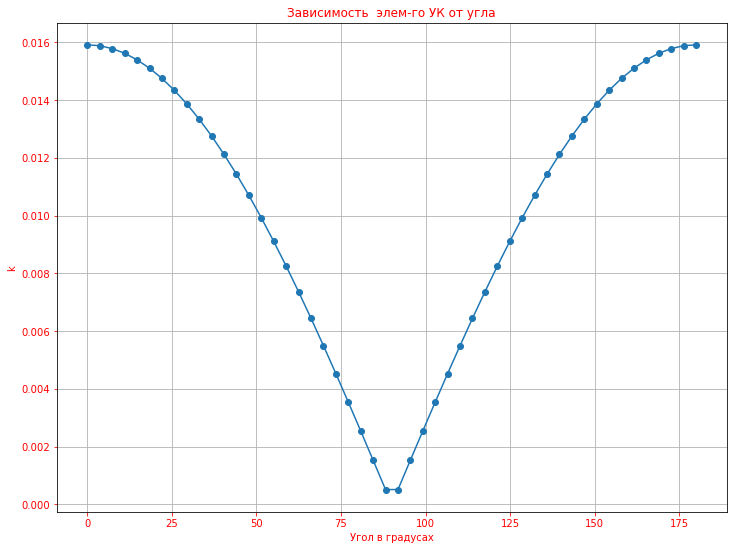

In [12]:
angles(50)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_12100/3921988960.py:15: RuntimeWarning: invalid value encountered in double_scalars
  cos_1 = abs( scalar_prod( normal_i, center_j - center_i ) ) / (r*n_i)
C:\Users\ASUS\AppData\Local\Temp/ipykernel_12100/3921988960.py:16: RuntimeWarning: invalid value encountered in double_scalars
  cos_2 = abs( scalar_prod( normal_j, center_i - center_j ) ) / (r*n_j)


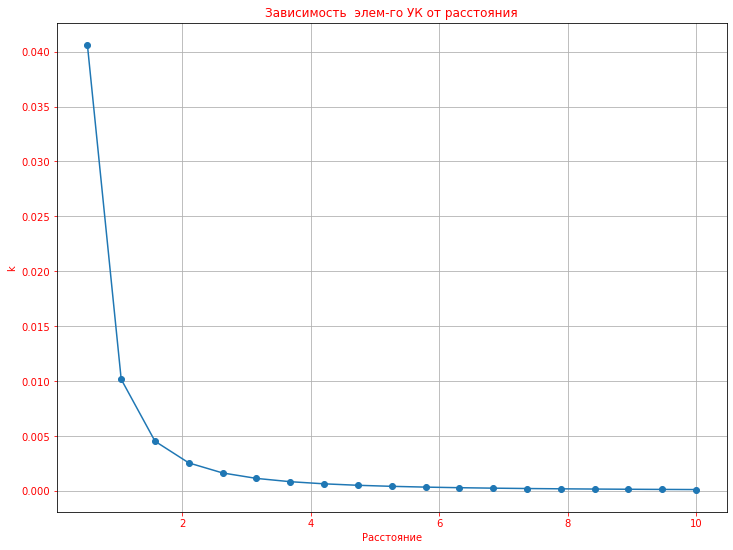

In [13]:
distance(20)